In [1]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
import pandas as pd
df = pd.read_csv("Electric_Vehicle_Population_By_County.csv", on_bad_lines='skip', engine='python')

In [3]:
# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
# Remove rows with invalid dates
df = df[df['Date'].notnull()]
# Ensure 'EV Total' is numeric
df['EV Total'] = pd.to_numeric(df['EV Total'], errors='coerce')
# Drop rows with missing EV Total values
df = df[df['EV Total'].notnull()]
# Fill missing 'County' and 'State' values
df['County'] = df['County'].fillna('Unknown')
df['State'] = df['State'].fillna('Unknown')
# Check for remaining nulls
print("Missing after fill:")
print(df[['County', 'State']].isnull().sum())
# Preview cleaned DataFrame
df.head()

Missing after fill:
County    0
State     0
dtype: int64


,Date,County,State,Vehicle Primary Use,Battery EVs (BEVs),Plug-In Hybrid EVs (PHEVs),EV Total,Non-EV Total,Total Vehicles,Percent EV
0,2022-09-30,Riverside,CA,Passenger,7,0,7.0,460,467,1.50
1,2022-12-31,Prince William,VA,Passenger,1,2,3.0,188,191,1.57
2,2020-01-31,Dakota,MN,Passenger,0,1,1.0,32,33,3.03
3,2022-06-30,Ferry,WA,Truck,0,0,0.0,"3,575","3,575",0.00
4,2021-07-31,Douglas,CO,Passenger,0,1,1.0,83,84,1.19


In [4]:
cols_to_convert = [
    'Battery EVs (BEVs)',
    'Plug-In Hybrid EVs (PHEVs)',
    'EV Total',
    'Non-EV Total',
    'Total Vehicles',
    'Percent EV'
]

for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df[cols_to_convert].describe()

,Battery EVs (BEVs),Plug-In Hybrid EVs (PHEVs),EV Total,Non-EV Total,Total Vehicles,Percent EV
count,20119.000000,20119.000000,20119.000000,13983.000000,13979.000000,20119.000000
mean,20.162831,11.460261,31.623093,132.845312,134.463767,4.231878
std,76.944236,41.608477,115.742017,174.033916,174.448753,11.233203
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,1.000000,26.000000,27.000000,0.360000
50%,1.000000,1.000000,1.000000,69.000000,70.000000,1.220000
75%,2.000000,1.000000,3.000000,167.000000,169.000000,3.090000
max,961.000000,444.000000,999.000000,999.000000,998.000000,100.000000


In [5]:
# Most EVs by County
top_counties = df.groupby('County')['EV Total'].sum().sort_values(ascending=False).head(3)
bottom_counties = df.groupby('County')['EV Total'].sum().sort_values().head(3)

print("Top 3 Counties:\n", top_counties)
print("\nBottom 3 Counties:\n", bottom_counties)

Top 3 Counties:
 County
Clallam      39839.0
Jefferson    39683.0
San Juan     39309.0
Name: EV Total, dtype: float64

Bottom 3 Counties:
 County
Brown         1.0
Hood River    1.0
Union         1.0
Name: EV Total, dtype: float64


In [6]:
import matplotlib.pyplot as plt

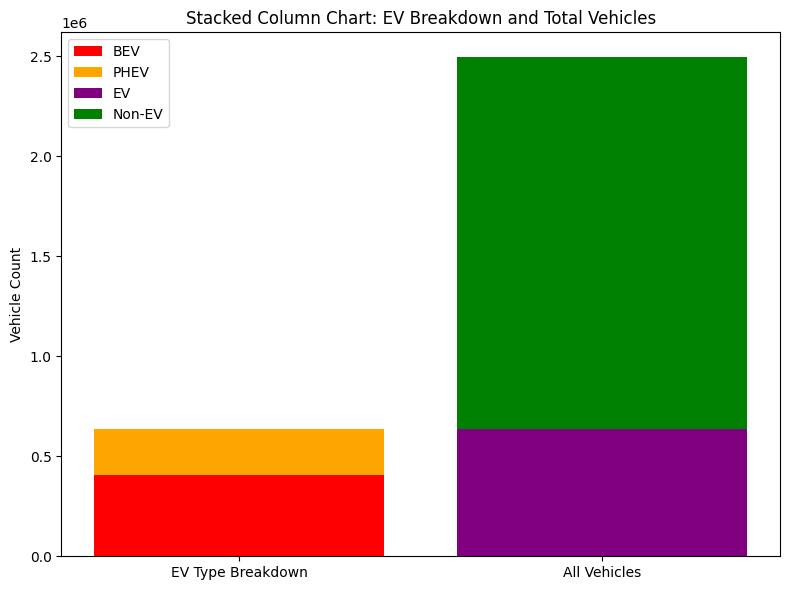

In [7]:
# Total sums for stacked column chart
bev_total = df['Battery EVs (BEVs)'].sum()
phev_total = df['Plug-In Hybrid EVs (PHEVs)'].sum()
ev_total = df['EV Total'].sum()
non_ev_total = df['Non-EV Total'].sum()
all_total = df['Total Vehicles'].sum()

# Stacked column chart
fig, ax = plt.subplots(figsize=(8, 6))

# Stack EV types
ax.bar('EV Type Breakdown', bev_total, label='BEV', color='red')
ax.bar('EV Type Breakdown', phev_total, bottom=bev_total, label='PHEV', color='orange')

# Stack Total Vehicle categories
ax.bar('All Vehicles', ev_total, label='EV', color='purple')
ax.bar('All Vehicles', non_ev_total, bottom=ev_total, label='Non-EV', color='green')

# Final touches
ax.set_ylabel('Vehicle Count')
ax.set_title('Stacked Column Chart: EV Breakdown and Total Vehicles')
ax.legend()
plt.tight_layout()
plt.show()


In [8]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Ensure 'Date' is datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop rows where 'Date' couldn't be parsed
df = df[df['Date'].notnull()]

# Extract year, month, and numeric date
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['numeric_date'] = df['year'] * 12 + df['month']

# Encode County
le = LabelEncoder()
df['county_encoded'] = le.fit_transform(df['County'])

# Sort by County and Date for time-based operations
df = df.sort_values(['County', 'Date'])

In [9]:
print(df.dtypes)

Date                          datetime64[ns]
County                                object
State                                 object
Vehicle Primary Use                   object
Battery EVs (BEVs)                     int64
Plug-In Hybrid EVs (PHEVs)             int64
EV Total                             float64
Non-EV Total                         float64
Total Vehicles                       float64
Percent EV                           float64
year                                   int32
month                                  int32
numeric_date                           int32
county_encoded                         int64
dtype: object


In [10]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [11]:
# Assign time index per county
df['months_since_start'] = df.groupby('County').cumcount()

#Lags are only based on past data from the same county
# === Create lag features (1–3 months) ===
for lag in [1, 2, 3]:
    df[f'ev_total_lag{lag}'] = df.groupby('County')['EV Total'].shift(lag)

# === Rolling average (3-month, prior) ===
df['ev_total_roll_mean_3'] = df.groupby('County')['EV Total'] \
                               .transform(lambda x: x.shift(1).rolling(3).mean())

# === Percent change (no fill method) ===
df['ev_total_pct_change_1'] = df.groupby('County')['EV Total'] \
                                .pct_change(periods=1, fill_method=None)

df['ev_total_pct_change_3'] = df.groupby('County')['EV Total'] \
                                .pct_change(periods=3, fill_method=None)

# === Clean up any infs/NaNs ===
df['ev_total_pct_change_1'] = df['ev_total_pct_change_1'].replace([np.inf, -np.inf], np.nan).fillna(0)
df['ev_total_pct_change_3'] = df['ev_total_pct_change_3'].replace([np.inf, -np.inf], np.nan).fillna(0)

In [12]:
# Cumulative EV count per county
df['cumulative_ev'] = df.groupby('County')['EV Total'].cumsum()

# 6-month rolling linear slope of cumulative growth
df['ev_growth_slope'] = df.groupby('County')['cumulative_ev'].transform(
    lambda x: x.rolling(6).apply(lambda y: np.polyfit(range(len(y)), y, 1)[0] if len(y) == 6 else np.nan)
)

In [13]:
# Drop early rows with no lag data
df = df.dropna().reset_index(drop=True)

In [14]:
df.to_csv('preprocessed_ev_data.csv', index=False)
df.head()

,Date,County,State,Vehicle Primary Use,Battery EVs (BEVs),Plug-In Hybrid EVs (PHEVs),EV Total,Non-EV Total,Total Vehicles,Percent EV,...,county_encoded,months_since_start,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,cumulative_ev,ev_growth_slope
0,2018-05-31,Ada,ID,Passenger,0,2,2.0,341.0,343.0,0.58,...,0,5,2.0,2.0,2.0,2.0,0.0,0.0,10.0,1.857143
1,2018-06-30,Ada,ID,Passenger,0,2,2.0,332.0,334.0,0.60,...,0,6,2.0,2.0,2.0,2.0,0.0,0.0,12.0,2.000000
2,2018-07-31,Ada,ID,Passenger,0,2,2.0,329.0,331.0,0.60,...,0,7,2.0,2.0,2.0,2.0,0.0,0.0,14.0,2.000000
3,2018-08-31,Ada,ID,Passenger,0,2,2.0,325.0,327.0,0.61,...,0,8,2.0,2.0,2.0,2.0,0.0,0.0,16.0,2.000000
4,2018-09-30,Ada,ID,Passenger,0,2,2.0,327.0,329.0,0.61,...,0,9,2.0,2.0,2.0,2.0,0.0,0.0,18.0,2.000000


In [15]:
# Define features and target
features = [
    'months_since_start',
    'county_encoded',
    'ev_total_lag1',
    'ev_total_lag2',
    'ev_total_lag3',
    'ev_total_roll_mean_3',
    'ev_total_pct_change_1',
    'ev_total_pct_change_3',
    'ev_growth_slope',
]

target = 'EV Total'
X = df[features]
y = df[target]

X.head()

,months_since_start,county_encoded,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,ev_growth_slope
0,5,0,2.0,2.0,2.0,2.0,0.0,0.0,1.857143
1,6,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
2,7,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
3,8,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
4,9,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000


In [16]:
from sklearn.model_selection import train_test_split

In [17]:
# Assume X and y are already defined
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False  # shuffle=False for time series
)

In [18]:
y_test.head()

11390    1.0
11391    1.0
11392    1.0
11393    1.0
11394    1.0
Name: EV Total, dtype: float64

In [19]:
X_test.head()

,months_since_start,county_encoded,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,ev_growth_slope
11390,89,270,1.0,1.0,1.0,1.0,0.0,0.0,1.0
11391,90,270,1.0,1.0,1.0,1.0,0.0,0.0,1.0
11392,91,270,1.0,1.0,1.0,1.0,0.0,0.0,1.0
11393,92,270,1.0,1.0,1.0,1.0,0.0,0.0,1.0
11394,93,270,1.0,1.0,1.0,1.0,0.0,0.0,1.0


In [20]:
from sklearn.ensemble import RandomForestRegressor

In [21]:
from sklearn.model_selection import RandomizedSearchCV

In [25]:
# Define param distribution
param_dist = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2', None]
}
# Base model
rf = RandomForestRegressor(random_state=42)
# Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,  # 30 random combos
    scoring='r2',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)
# Fit model
random_search.fit(X_train, y_train)
# Best model
model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 15}


In [23]:
# Predict and evaluate
y_pred = model.predict(X_test)

In [24]:
# Create a DataFrame with actual and predicted values
comparison_df = pd.DataFrame({
    'Actual EV Count': y_test.values,
    'Predicted EV Count': y_pred
})

# Round for readability
comparison_df['Predicted EV Count'] = comparison_df['Predicted EV Count'].round(2)

# Optionally reset index if needed
comparison_df.reset_index(drop=True, inplace=True)

# Show the first 10 rows
comparison_df.head(10)

,Actual EV Count,Predicted EV Count
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
5,1.0,1.0
6,1.0,1.0
7,1.0,1.0
8,1.0,1.0
9,1.0,1.0


In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [27]:
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2Score = r2_score(y_true, y_pred)
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2 Score: {r2Score:.2f}")

# Example usage (assuming y_test and y_pred are defined)
evaluate(y_test, y_pred)

MAE: 0.01, RMSE: 0.05, R2 Score: 1.00


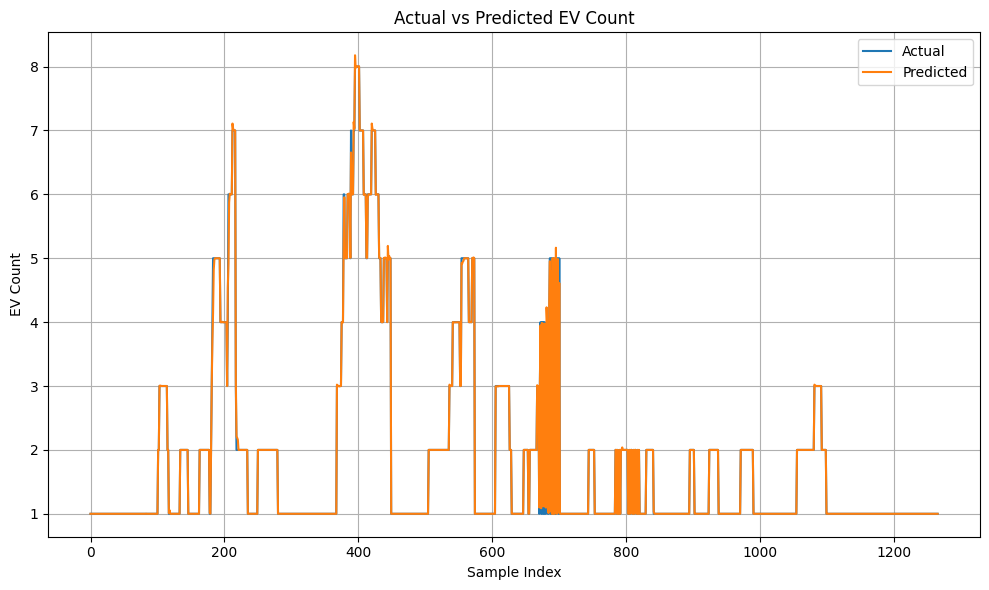

In [28]:
# Plot actual vs predicted
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Actual vs Predicted EV Count")
plt.xlabel("Sample Index")
plt.ylabel("EV Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

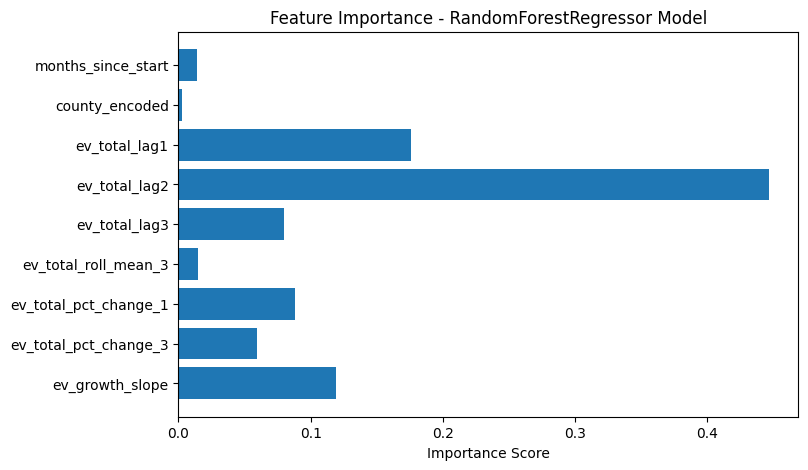

In [29]:
# Corrected the attribute name from get_feature_importance() to feature_importances_
importances = model.feature_importances_
# Plot feature importance
plt.figure(figsize=(8,5))
plt.barh(features, importances)
plt.xlabel('Importance Score')
# Updated the title to reflect that the model is RandomForestRegressor
plt.title('Feature Importance - RandomForestRegressor Model')
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()

In [30]:
# Define features and target
featuresX = ['County', 'county_encoded']
countyX = df[featuresX]
print("List of unique counties:")
print(df['County'].dropna().unique())
print("Total unique counties:", df['County'].nunique())

List of unique counties:
['Ada' 'Adams' 'Alameda' 'Albemarle' 'Alexandria' 'Allegheny' 'Allen'
 'Anchorage' 'Anne Arundel' 'Arapahoe' 'Arlington' 'Atlantic' 'Autauga'
 'Baltimore' 'Bartow' 'Beaufort' 'Bell' 'Bergen' 'Berkeley' 'Berkshire'
 'Bexar' 'Boone' 'Boulder' 'Bradley' 'Brevard' 'Broward' 'Bryan' 'Bucks'
 'Burlington' 'Caddo' 'Calvert' 'Camden' 'Canyon' 'Carroll' 'Carson City'
 'Cascade' 'Champaign' 'Charles' 'Charleston' 'Charlottesville'
 'Chesapeake' 'Clackamas' 'Clark' 'Clay' 'Clinton' 'Cobb' 'Cochise'
 'Collier' 'Collin' 'Columbia' 'Contra Costa' 'Cook' 'Coryell'
 'Cumberland' 'Currituck' 'Dakota' 'Dale' 'Dallas' 'Dane' 'Danville'
 'DeKalb' 'Denton' 'Denver' 'Deschutes' 'District of Columbia'
 'Dorchester' 'Douglas' 'DuPage' 'Duval' 'Eagle' 'Eau Claire' 'El Dorado'
 'El Paso' 'Escambia' 'Essex' 'Fairbanks North Star' 'Fairfax' 'Flathead'
 'Fort Bend' 'Franklin' 'Frederick' 'Fresno' 'Fulton' 'Galveston'
 'Garfield' 'Geary' 'Goochland' 'Greene' 'Guadalupe' 'Gwinnett' 'Hamilton

County 'Kings' encoded as 130.


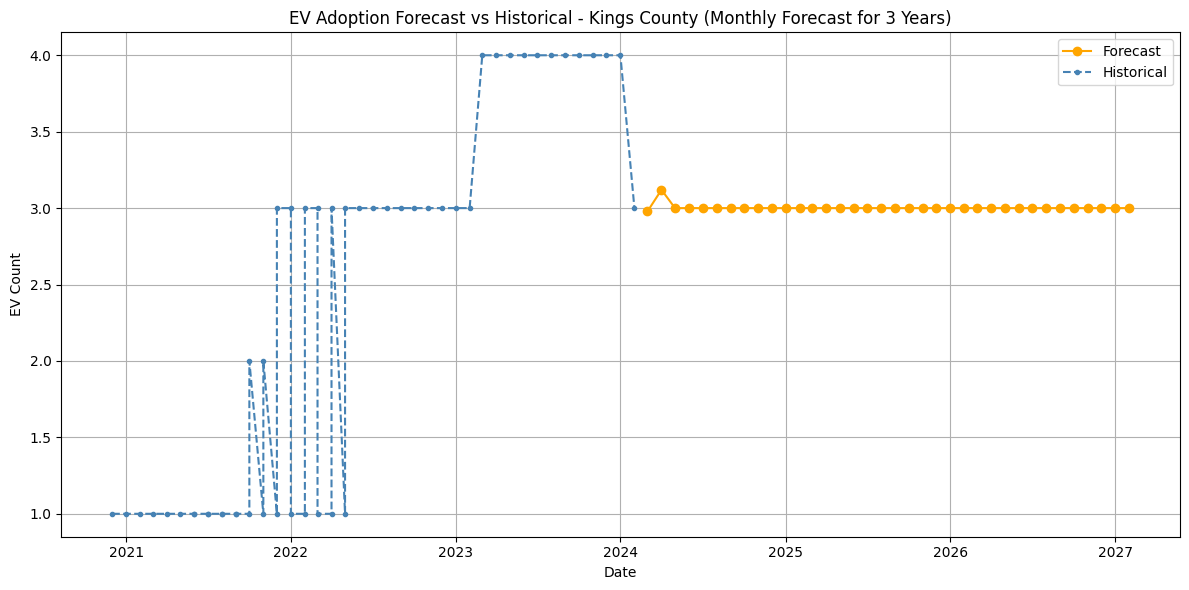

In [31]:
# Set your county name
county = "Kings"

# Encode county
try:
    county_code = le.transform([county])[0]
    print(f"County '{county}' encoded as {county_code}.")
except ValueError:
    print(f"Error: '{county}' not found in LabelEncoder.")
    exit()

# Filter historical data
county_df = df[df['county_encoded'] == county_code].sort_values("numeric_date")
if county_df.empty:
    print(f"Warning: No data found for county '{county}'.")
    exit()

# Prepare EV history
historical_ev = list(county_df['EV Total'].values[-6:])
cumulative_ev = list(np.cumsum(historical_ev))
slope_history = []
months_since_start = county_df['months_since_start'].max()

historical = county_df[['year', 'month', 'numeric_date', 'EV Total', 'months_since_start']].copy()
historical['Source'] = 'Historical'
historical['Date'] = pd.to_datetime(historical[['year', 'month']].assign(day=1))

# Forecast next 36 months
latest_row = county_df.iloc[-1].copy()
future_rows = []

for i in range(1, 37):
    next_date = pd.to_datetime(latest_row['year'] * 100 + latest_row['month'], format='%Y%m') + pd.DateOffset(months=1)
    y, m = next_date.year, next_date.month
    numeric_date = y * 12 + m
    months_since_start += 1

    lag1, lag2, lag3 = historical_ev[-1], historical_ev[-2], historical_ev[-3]
    roll_mean = np.mean([lag1, lag2, lag3])
    pct_change_1 = (lag1 - lag2) / lag2 if lag2 != 0 else 0
    pct_change_3 = (lag1 - lag3) / lag3 if lag3 != 0 else 0

    # Compute slope
    recent_cumulative = cumulative_ev[-6:]
    ev_growth_slope = np.polyfit(range(len(recent_cumulative)), recent_cumulative, 1)[0] if len(recent_cumulative) == 6 else 0

    # Construct new row
    new_row = {
        'months_since_start': months_since_start,
        'county_encoded': county_code,
        'ev_total_lag1': lag1,
        'ev_total_lag2': lag2,
        'ev_total_lag3': lag3,
        'ev_total_roll_mean_3': roll_mean,
        'ev_total_pct_change_1': pct_change_1,
        'ev_total_pct_change_3': pct_change_3,
        'ev_growth_slope': ev_growth_slope
    }

    # Predict
    X_new = pd.DataFrame([new_row])[features]
    pred = model.predict(X_new)[0]
    new_row['EV Total'] = pred

    # Update rolling histories
    historical_ev.append(pred)
    if len(historical_ev) > 6:
        historical_ev.pop(0)

    cumulative_ev.append(cumulative_ev[-1] + pred)
    if len(cumulative_ev) > 6:
        cumulative_ev.pop(0)

    future_rows.append({
        'Date': next_date,
        'EV Total': pred,
        'months_since_start': months_since_start,
        'Source': 'Forecast'
    })

    latest_row['year'], latest_row['month'] = y, m

# Forecast DataFrame
forecast_df = pd.DataFrame(future_rows)

# Combine and plot
historical['Date'] = pd.to_datetime(historical[['year', 'month']].assign(day=1))
historical = historical[['Date', 'EV Total', 'months_since_start', 'Source']]
combined = pd.concat([historical, forecast_df], ignore_index=True)

# Plot with custom colors
plt.figure(figsize=(12, 6))
for source, group in combined.groupby('Source'):
    plt.plot(
        group['Date'],
        group['EV Total'],
        label=source,
        color='orange' if source == 'Forecast' else 'steelblue',  # custom colors
        marker='o' if source == 'Forecast' else '.',
        linestyle='-' if source == 'Forecast' else '--'
    )

plt.title(f"EV Adoption Forecast vs Historical - {county} County (Monthly Forecast for 3 Years)")
plt.xlabel("Date")
plt.ylabel("EV Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


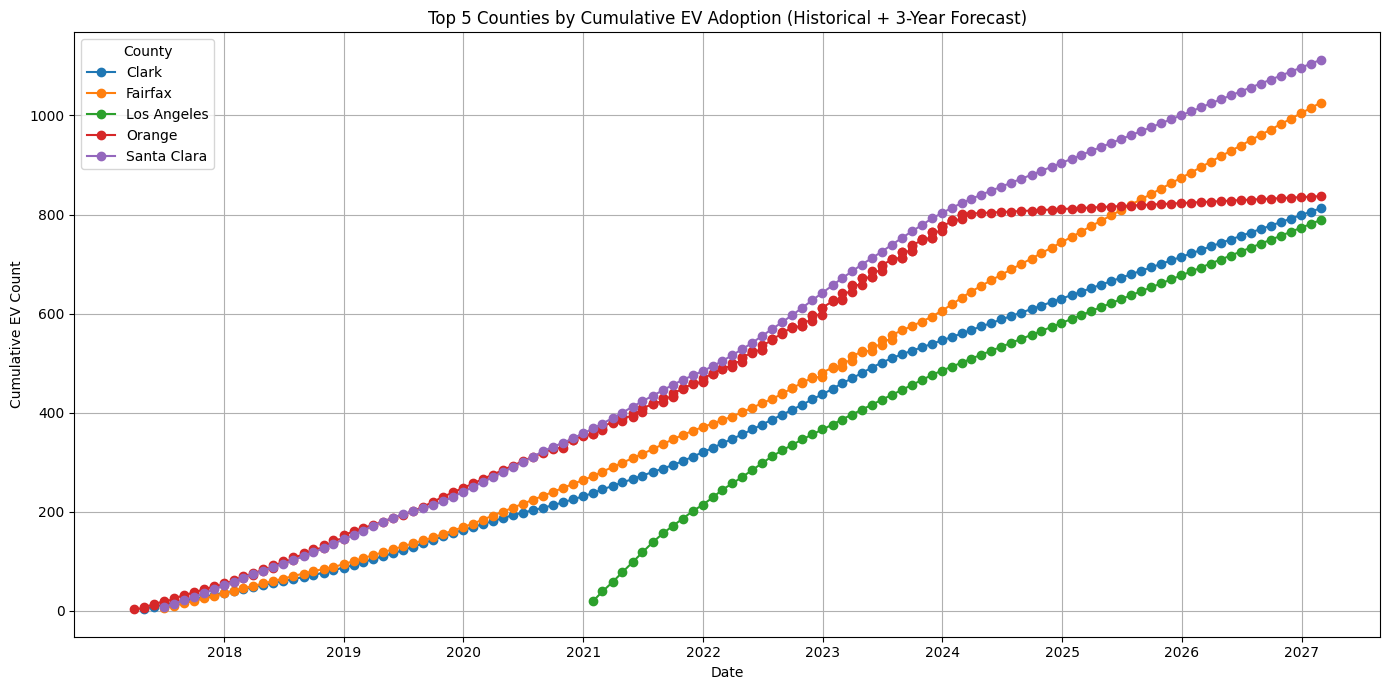

In [32]:
forecast_horizon = 36  # 3 years = 36 months

all_combined = []
unique_counties = df['County'].dropna().unique()

for county in unique_counties:
    try:
        county_code = le.transform([county])[0]
    except ValueError:
        continue

    county_df = df[df['county_encoded'] == county_code].sort_values("numeric_date")
    if county_df.empty or county_df.shape[0] < 6:
        continue

    # Extract initial months_since_start
    months_since_start = county_df['months_since_start'].max()

    historical = county_df[['Date', 'EV Total', 'months_since_start']].copy()
    historical['Source'] = 'Historical'
    historical['County'] = county

    historical_ev = list(county_df['EV Total'].values[-6:])
    cumulative_ev = list(np.cumsum(historical_ev))
    slope_history = []

    future_rows = []

    for _ in range(forecast_horizon):
        months_since_start += 1

        lag1, lag2, lag3 = historical_ev[-1], historical_ev[-2], historical_ev[-3]
        roll_mean = np.mean([lag1, lag2, lag3])
        pct_change_1 = (lag1 - lag2) / lag2 if lag2 != 0 else 0
        pct_change_3 = (lag1 - lag3) / lag3 if lag3 != 0 else 0

        recent_cumulative = cumulative_ev[-6:]
        ev_growth_slope = np.polyfit(range(len(recent_cumulative)), recent_cumulative, 1)[0] if len(recent_cumulative) == 6 else 0

        # Optional: track slope history for acceleration (not used here)
        slope_history.append(ev_growth_slope)
        if len(slope_history) > 2:
            slope_history.pop(0)

        new_row = {
            'months_since_start': months_since_start,
            'county_encoded': county_code,
            'ev_total_lag1': lag1,
            'ev_total_lag2': lag2,
            'ev_total_lag3': lag3,
            'ev_total_roll_mean_3': roll_mean,
            'ev_total_pct_change_1': pct_change_1,
            'ev_total_pct_change_3': pct_change_3,
            'ev_growth_slope': ev_growth_slope
        }

        # Predict
        X_new = pd.DataFrame([new_row])[features]
        pred = model.predict(X_new)[0]
        new_row['EV Total'] = pred

        # Store for plotting
        forecast_date = historical['Date'].max() + pd.DateOffset(months=len(future_rows) + 1)
        future_rows.append({
            'Date': forecast_date,
            'EV Total': pred,
            'months_since_start': months_since_start,
            'County': county,
            'Source': 'Forecast'
        })

        # Update EV history
        historical_ev.append(pred)
        if len(historical_ev) > 6:
            historical_ev.pop(0)

        cumulative_ev.append(cumulative_ev[-1] + pred)
        if len(cumulative_ev) > 6:
            cumulative_ev.pop(0)

    forecast_df = pd.DataFrame(future_rows)
    combined = pd.concat([historical, forecast_df], ignore_index=True)
    combined = combined.sort_values("Date")
    combined['Cumulative EVs'] = combined['EV Total'].cumsum()

    all_combined.append(combined)

# Combine all counties
full_df = pd.concat(all_combined)

# Get final cumulative EV count per county
final_totals = full_df.groupby('County')['Cumulative EVs'].max().sort_values(ascending=False)
top_5_counties = final_totals.head(5).index.tolist()

# Filter top 5 counties
top_5_df = full_df[full_df['County'].isin(top_5_counties)]

# Plot
plt.figure(figsize=(14, 7))
for county, group in top_5_df.groupby('County'):
    plt.plot(group['Date'], group['Cumulative EVs'], label=county, marker='o')

# Format x-axis to show one tick per year
plt.title("Top 5 Counties by Cumulative EV Adoption (Historical + 3-Year Forecast)")
plt.xlabel("Date")
plt.ylabel("Cumulative EV Count")
plt.grid(True)
plt.legend(title="County")
plt.xticks(
    ticks=pd.date_range(start=top_5_df['Date'].min(), end=top_5_df['Date'].max(), freq='YS'),
    labels=[str(d.year) for d in pd.date_range(start=top_5_df['Date'].min(), end=top_5_df['Date'].max(), freq='YS')],
    rotation=0
)
plt.tight_layout()
plt.show()

In [33]:
import joblib

# Save the trained model to file
joblib.dump(model, 'forecasting_ev_model.pkl')
print("Model saved to 'forecasting_ev_model.pkl'")

Model saved to 'forecasting_ev_model.pkl'


In [34]:
# Load model from file
loaded_model = joblib.load('forecasting_ev_model.pkl')
print("Model loaded successfully.")

Model loaded successfully.


In [35]:
# Make predictions
# Test prediction on new or existing sample
sample = X_test.iloc[[0]]  # use one row as test
true_value = y_test.iloc[0]
predicted_value = loaded_model.predict(sample)[0]

print(f"\n🔍 Testing saved model on 1 sample:")
print(f"Actual EVs: {true_value:.2f}, Predicted EVs: {predicted_value:.2f}")


🔍 Testing saved model on 1 sample:
Actual EVs: 1.00, Predicted EVs: 1.00
